#### This notebook is for loading data from Deeplabcut and running classification model 

In [2]:
import sys
sys.path.insert(0, '../')
import movement_classifier.utils as utils
import movement_classifier.data_loader as data_loader
import movement_classifier.model_funcs as model_funcs
import movement_classifier.reverse_model as reverse_model

from os.path import dirname, join as pjoin
import os

import math

import dlc2kinematics
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import torch
import pandas as pd
import plotly.express as px
import plotly
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.io as sio


0.0
2.4748737341529163


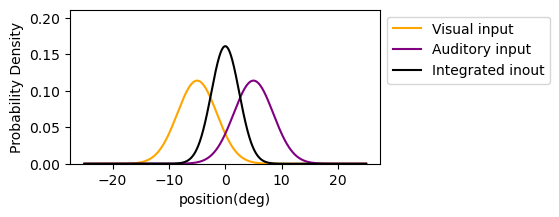

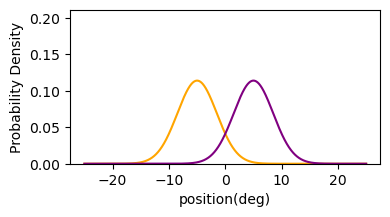

In [61]:
# my python test for NSCI 401 (temporary code)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the first normal distribution
mean1 = -5
std_dev1 = 3.5

# Parameters for the second normal distribution
mean2 = 5
std_dev2 = 3.5

# Define the range for the x-axis
x = np.linspace(-25, 25, 2000)
std_dev3 = np.sqrt(1/((1/std_dev1**2) + (1/std_dev2**2)))
mean3= (std_dev3**2) * ((mean1/std_dev1**2) + (mean2/std_dev2**2))
print(mean3)
print(std_dev3)
# Calculate the probability density functions (PDFs)
pdf1 = norm.pdf(x, mean1, std_dev1)
pdf2 = norm.pdf(x, mean2, std_dev2)
pdf3 = norm.pdf(x, mean3, std_dev3)
# Create the plot
plt.figure(figsize=(4, 2))
plt.plot(x, pdf1, label='Visual input', color='orange')
plt.plot(x, pdf2, label='Auditory input', color='purple')
plt.plot(x, pdf3, label='Integrated inout', color='black')
# plt.title('Plot of Two Normal Distributions')
plt.xlabel('position(deg)')
plt.ylabel('Probability Density')
# plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.grid()
plt.ylim(0, max(pdf1.max(), pdf2.max(),pdf3.max()) + 0.05)
plt.show()



plt.figure(figsize=(4, 2))
plt.plot(x, pdf1, label='Visual input', color='orange')
plt.plot(x, pdf2, label='Auditory input', color='purple')
# plt.plot(x, pdf3, label='Integrated inout', color='black')
# plt.title('Plot of Two Normal Distributions')
plt.xlabel('position(deg)')
plt.ylabel('Probability Density')
plt.ylim(0, max(pdf1.max(), pdf2.max(),pdf3.max()) + 0.05)
plt.show()



In [21]:
np.random.normal(55, 10, 12)


array([51.70710493, 64.41014595, 60.51079132, 52.51861591, 66.70911646,
       58.71818401, 59.13618425, 40.65731911, 65.39686276, 44.04719673,
       57.25966889, 60.57931675])

In [14]:
np.mean( [38.96, 35.34,52.89,45.90, 47.78,46.21, 47.77,37.20, 59.89, 63.84,55.42, 37.33])

47.3775

In [15]:
np.std([38.96, 35.34,52.89,45.90, 47.78,46.21, 47.77,37.20, 59.89, 63.84,55.42, 37.33])

8.882556055738311

In [16]:
np.mean( [38.92, 28.53,44.16,41.43, 24.38,50.55,38.04,30.55 ,55.17,54.13,43.47,43.01])

41.028333333333336

In [17]:
np.std( [38.92, 28.53,44.16,41.43, 24.38,50.55,38.04,30.55 ,55.17,54.13,43.47,43.01])

9.3036998315485

In [18]:
print(np.mean([56.54, 48.52, 47.02, 53.25, 58.63,71.37 ,70.15, 51.41, 45.38, 46.41,49.00, 61.30]))
np.std([56.54, 48.52, 47.02, 53.25, 58.63,71.37 ,70.15, 51.41, 45.38, 46.41,49.00, 61.30])

54.91499999999999


8.546954135831081

In [19]:
np.mean( [45.16,42.29,27.92 ,34.98,35.19,40.53,24.32,28.17,35.12,31.73,58.58, 39.57])

36.96333333333333

In [1]:
np.std([45.16,42.29,27.92 ,34.98,35.19,40.53,24.32,28.17,35.12,31.73,58.58, 39.57])

NameError: name 'np' is not defined

In [6]:
dataset = np.random.normal(50, 10, 10)
np.random.normal(50, 10, 12)
p = [47.59234279, 54.87853133, 70.854146  , 28.50265736, 55.73617616,
       39.38789941, 46.55675351, 48.13677913, 53.55634925, 39.39606941,
       42.83453697, 43.11346213]
np.mean(p)
# np.random.normal(40, 10, 12)

47.545475287500004

In [2]:
"""Load raw data and create Dataframe of all subjects and their movements and save them"""
min_length,max_length,_,_ = data_loader.timelength_loader("../data/01_raw/F_Subjects")
sub_info,movement_name_list,subjects = data_loader.csvSubject_loader("../data/01_raw/CSV_files",min_length,max_length,method="interpolation")
data_loader.save_data(sub_info, movement_name_list,subjects, method = "interpolation")

all Dataframs have been created!
all Dataframes have been saved properly


In [3]:
"""load dataframes for the modelling"""
path_file = "../data/03_processed/padding"
data_dict = data_loader.load_data_dict(path_file)
data_dict.keys()
np.unique(data_dict["labels_name"])

array(['checking_watch', 'crawling', 'cross_legged_sitting', 'crossarms',
       'hand_clapping', 'hand_waving', 'jogging', 'jumping_jacks',
       'kicking', 'phone_talking', 'pointing', 'running_in_spot',
       'scratching_head', 'sideways', 'sitting_down', 'stretching',
       'taking_photo', 'throw/catch', 'vertical_jumping', 'walking'],
      dtype='<U20')

In [11]:

### Extract two/three classes data for two-class classifier
# np.unique(data_dict["labels_name"])
ind = np.where(np.logical_or(np.logical_or(data_dict["labels_name"] == "walking" , data_dict["labels_name"] == 'jumping_jacks'), data_dict["labels_name"] == 'jogging'))
p = ['input_model', 'labels', 'labels_name']
input_dict ={}
for k in p:
    print(k)
    input_dict[k]= data_dict[k][ind]
    input_dict[k].shape
input_dict["labels"]


labels = input_dict["labels"]
labels[labels== 7]= 0
labels[labels== 19]= 1
labels[labels== 6]= 2
input_dict["labels"] = labels

input_model
labels
labels_name


array([ 7, 19,  6,  7,  6, 19,  7,  6, 19,  7,  6, 19,  6,  7, 19, 19,  6,
        7, 19,  6,  7,  7, 19,  6,  7,  6, 19, 19,  7,  6, 19,  6,  7,  7,
       19,  6,  7,  6, 19, 19,  7,  6, 19,  6,  7,  6,  7, 19, 19,  6,  7,
        7,  6, 19,  7,  6, 19, 19,  7,  6,  7, 19,  6,  7, 19,  6,  7,  6,
       19, 19,  7,  6,  7,  6, 19,  6, 19,  7,  7, 19,  6,  7, 19,  6, 19,
        6,  7,  7,  6, 19,  7,  6, 19,  6,  7, 19, 19,  7,  6, 19,  6,  7,
       19,  7,  6,  7,  6, 19,  7,  6, 19,  6,  7, 19,  7, 19,  6,  7, 19,
        6, 19,  6,  7,  6,  7, 19, 19,  7,  6,  7, 19,  6, 19,  6,  7,  7,
        6, 19,  7, 19,  6, 19,  6,  7, 19,  6,  7, 19,  7,  6,  6, 19,  7,
        6, 19,  7,  7, 19,  6])

In [4]:

""" Run functions for the model"""

model1 = model_funcs.Mov1DCNN(num_classes = 20)
input_dict = data_dict
reg = "l2"
params = (model1 , input_dict   , reg )
my_testmodel = model_funcs.ModelHandler(*params)
"""train model"""
my_testmodel.train()
"""test model"""
my_testmodel.test()
"""plot confusionmatrix"""
# my_testmodel.plotConfusionMatrix()
"""plot RDM for input and fully connected layers"""
# visualization_train,labels_name_train,output_train= my_testmodel.layer_extractor(train=True)
# my_testmodel.save_layerOutput(train = True)
# visualization_test,labels_name_test,output_train= my_testmodel.layer_extractor(train=False)
# my_testmodel.save_layerOutput(train = False)
# out_fc1= np.load("../data/03_processed/fc1-out.npy")
# out_fc2= np.load("../data/03_processed/fc2-out.npy")
# out_fc3= np.load("../data/03_processed/fc3-out.npy")
# my_testmodel.plotRDM(plot_input=True)
# my_testmodel.plotRDM(plot_input=False)


Epoch [1/200], Step [2/9], Loss: 27.9212, Accuracy: 8.00%
Epoch [1/200], Step [4/9], Loss: 4.4103, Accuracy: 13.00%
Epoch [1/200], Step [6/9], Loss: 3.8477, Accuracy: 6.00%
Epoch [1/200], Step [8/9], Loss: 3.6175, Accuracy: 8.00%
Epoch [2/200], Step [2/9], Loss: 3.3532, Accuracy: 21.00%
Epoch [2/200], Step [4/9], Loss: 2.9877, Accuracy: 32.00%
Epoch [2/200], Step [6/9], Loss: 2.8783, Accuracy: 40.00%
Epoch [2/200], Step [8/9], Loss: 2.4175, Accuracy: 56.00%
Epoch [3/200], Step [2/9], Loss: 2.6681, Accuracy: 42.00%
Epoch [3/200], Step [4/9], Loss: 2.2884, Accuracy: 54.00%
Epoch [3/200], Step [6/9], Loss: 2.5329, Accuracy: 41.00%
Epoch [3/200], Step [8/9], Loss: 2.4352, Accuracy: 41.00%
Epoch [4/200], Step [2/9], Loss: 2.3731, Accuracy: 46.00%
Epoch [4/200], Step [4/9], Loss: 2.5935, Accuracy: 37.00%
Epoch [4/200], Step [6/9], Loss: 2.2385, Accuracy: 54.00%
Epoch [4/200], Step [8/9], Loss: 2.3744, Accuracy: 48.00%
Epoch [5/200], Step [2/9], Loss: 1.9922, Accuracy: 65.00%
Epoch [5/200], S

'plot RDM for input and fully connected layers'

In [7]:
def plot_difconfmat(in1,in2):
    model1 = model_funcs.Mov1DCNN()
    path_file = "../data/03_processed/"+in1
    data_dict = data_loader.load_data_dict(path_file)   
    input_dict = data_dict
    reg = "l2"
    params = (model1 , input_dict   , reg )
    m1 = model_funcs.ModelHandler(*params)
    m1.train()
    m1.test()
    conf1,tick_names = m1.plotConfusionMatrix()

    model2 = model_funcs.Mov1DCNN()
    path_file = "../data/03_processed/"+in2
    data_dict = data_loader.load_data_dict(path_file)   
    input_dict = data_dict
    reg = "l2"
    params = (model2 , input_dict   , reg )
    m2 = model_funcs.ModelHandler(*params)
    m2.train()
    m2.test()
    conf2,tick_names = m2.plotConfusionMatrix()

    plt.figure(figsize=(8,10))
    plt.imshow(conf1-conf2)
    plt.colorbar(orientation="horizontal")
    plt.xticks(range(len(tick_names)),tick_names, rotation=90)
    plt.yticks(range(len(tick_names)),tick_names)
    plt.xlabel('predicted move')
    plt.ylabel('real move')
    plt.show()
    return(conf1,conf2)

Epoch [1/200], Step [2/6], Loss: 85.4876, Accuracy: 4.00%
Epoch [1/200], Step [4/6], Loss: 11.7506, Accuracy: 4.00%
Epoch [1/200], Step [6/6], Loss: 3.8074, Accuracy: 17.33%
Epoch [2/200], Step [2/6], Loss: 3.8470, Accuracy: 12.00%
Epoch [2/200], Step [4/6], Loss: 3.6466, Accuracy: 19.00%
Epoch [2/200], Step [6/6], Loss: 4.0962, Accuracy: 8.00%
Epoch [3/200], Step [2/6], Loss: 3.6732, Accuracy: 21.00%
Epoch [3/200], Step [4/6], Loss: 3.7442, Accuracy: 25.00%
Epoch [3/200], Step [6/6], Loss: 3.6591, Accuracy: 22.67%
Epoch [4/200], Step [2/6], Loss: 3.5323, Accuracy: 22.00%
Epoch [4/200], Step [4/6], Loss: 3.5646, Accuracy: 22.00%
Epoch [4/200], Step [6/6], Loss: 3.5565, Accuracy: 25.33%
Epoch [5/200], Step [2/6], Loss: 3.2536, Accuracy: 34.00%
Epoch [5/200], Step [4/6], Loss: 3.5032, Accuracy: 24.00%
Epoch [5/200], Step [6/6], Loss: 3.1406, Accuracy: 52.00%
Epoch [6/200], Step [2/6], Loss: 3.4852, Accuracy: 32.00%
Epoch [6/200], Step [4/6], Loss: 3.6635, Accuracy: 34.00%
Epoch [6/200], 

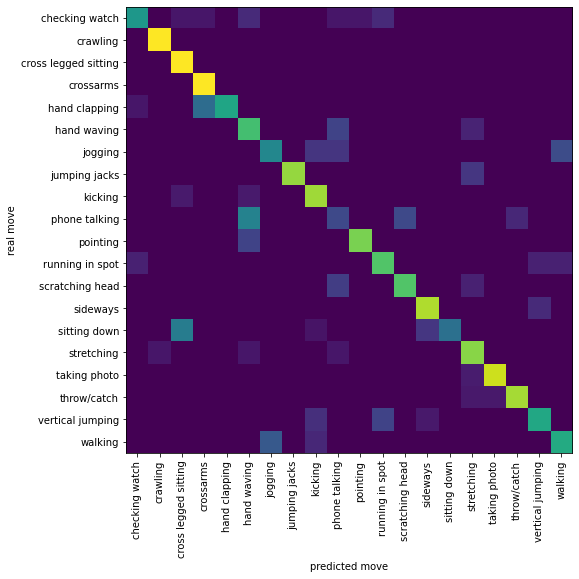

Epoch [1/200], Step [2/6], Loss: 15.8932, Accuracy: 10.00%
Epoch [1/200], Step [4/6], Loss: 4.3434, Accuracy: 15.00%
Epoch [1/200], Step [6/6], Loss: 3.7729, Accuracy: 8.00%
Epoch [2/200], Step [2/6], Loss: 3.5691, Accuracy: 15.00%
Epoch [2/200], Step [4/6], Loss: 3.5968, Accuracy: 12.00%
Epoch [2/200], Step [6/6], Loss: 3.6128, Accuracy: 18.67%
Epoch [3/200], Step [2/6], Loss: 3.3829, Accuracy: 23.00%
Epoch [3/200], Step [4/6], Loss: 3.0949, Accuracy: 24.00%
Epoch [3/200], Step [6/6], Loss: 3.0361, Accuracy: 18.67%
Epoch [4/200], Step [2/6], Loss: 3.0196, Accuracy: 24.00%
Epoch [4/200], Step [4/6], Loss: 2.8275, Accuracy: 35.00%
Epoch [4/200], Step [6/6], Loss: 2.6382, Accuracy: 44.00%
Epoch [5/200], Step [2/6], Loss: 2.4743, Accuracy: 47.00%
Epoch [5/200], Step [4/6], Loss: 2.4902, Accuracy: 42.00%
Epoch [5/200], Step [6/6], Loss: 2.3108, Accuracy: 53.33%
Epoch [6/200], Step [2/6], Loss: 2.3218, Accuracy: 49.00%
Epoch [6/200], Step [4/6], Loss: 2.2008, Accuracy: 49.00%
Epoch [6/200],

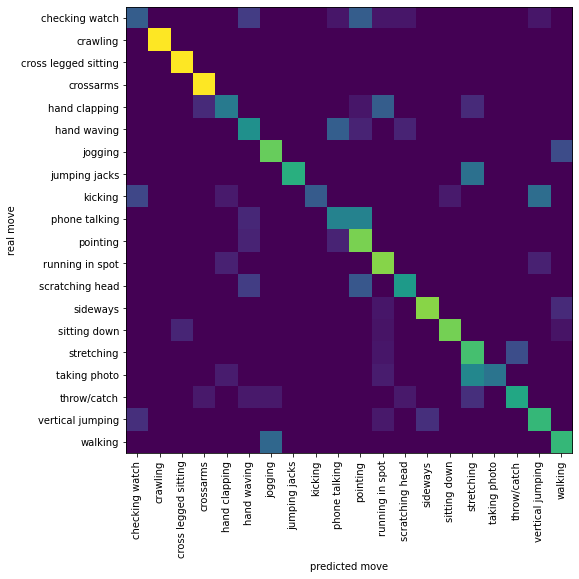

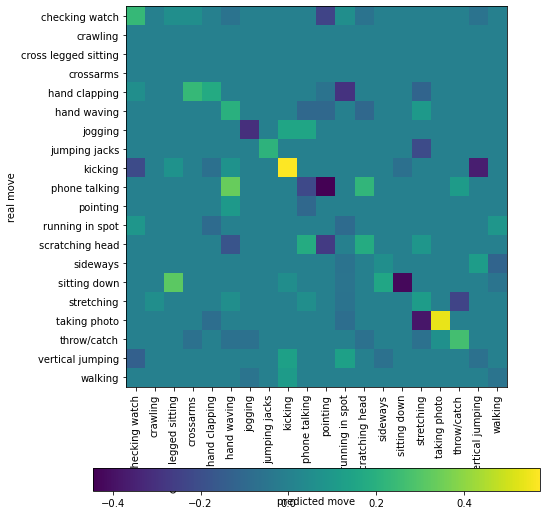

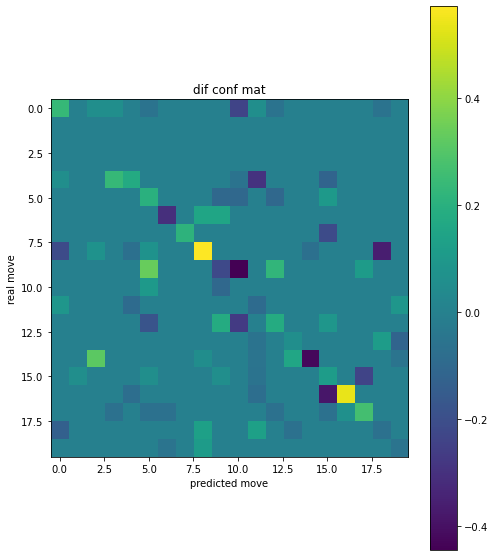

In [4]:
conf1,conf2 = plot_difconfmat("interpolation","padding")
plt.figure(figsize=(8,10))
plt.imshow(conf1-conf2)
plt.colorbar()
# plt.xticks(range(len(tick_names)),tick_names, rotation=90)
# plt.yticks(range(len(tick_names)),tick_names)
plt.xlabel('predicted move')
plt.ylabel('real move')
plt.title("dif conf mat")
plt.show()

In [ ]:
"""test new library of DLC2kinematics"""

# load dlc2kinematics to add velocity and angular 
df, bodyparts, scorer = dlc2kinematics.load_data("/home/arefe/My Project/data/01_raw/h5files/F_PG1_Subject_21_LDLC_resnet101_myDLC_21_25Nov17shuffle1_103000.h5")
# it gives dataframe of velocity for each 42 channel
df_vel = dlc2kinematics.compute_velocity(df,bodyparts=['all'])
# joint_dict= {}
# joint_dict['R-Elbow']  = ['R_shoulder', 'Right_elbow', 'Right_wrist']
# joint_angles = dlc2kinematics.compute_joint_angles(df,joint_dict)
# joint_vel = dlc2kinematics.compute_joint_velocity(joint_angles)
# pca = dlc2kinematics.compute_pca(joint_vel, plot=True)
dlc2kinematics.plot_3d_pca_reconstruction(df_vel, n_components=10, framenumber=500)





"""plot length distribution of each movement """
_,_,subjects,all_motions_dist= data_loader.timelength_loader("../data/01_raw/F_Subjects")

motions_dist_mean = {}
motions_dist_std = {}
for k in all_motions_dist.keys():
    motions_dist_mean[k] = np.mean(all_motions_dist[k])
    motions_dist_std[k] = np.std(all_motions_dist[k])
positions = all_motions_dist.keys()
plt.figure(figsize=(8,6))
plt.bar(positions, motions_dist_mean.values(), color="Cyan", yerr=motions_dist_std.values())
plt.xticks(rotation=30)
plt.show()

# dlc2kinematics.compute_umap(df, key=['LeftForelimb', 'RightForelimb'], chunk_length=30,fit_transform=True, n_neighbors=30, n_components=3,metric="euclidean")

In [1]:
location1 = "right"
location2 = "middle"
location3 = "left"

In [4]:
len(location1)

5

In [16]:
print("-"*(20-len(location1))+location1)
print("-"*7+location2+"-"*7)
print(location3+"-"*(20-len(location3)))

---------------right
-------middle-------
left----------------


In [ ]:
---------------right
-------middle-------
left----------------

In [ ]:
breakfast = input("enter the cost of your breakfast")
lunch = input("enter the cost of your lunch")
dinner = input("enter the cost of dinner")
def show_cost(breakfat , lunch, dinner):
    total = breakfast+lunch+dinner
    print(total)

In [ ]:
breakfast = Int(input("enter the cost of your breakfast"))

5


In [ ]:
breakfast_cost = 5
lunch_cost = 10
print(breakfast_cost+lunch_cost)

15